# Setting up the environment

In [2]:
from google.colab import drive
import os
from google.colab import userdata

# Step 1: Mount Google Drive
# Mount Google Drive to access your GitHub repository
drive.mount('/content/drive', force_remount=True)

# Step 2: Navigate to Your GitHub Repository
# Change to your repository's location in Google Drive
repo_path = "/content/drive/MyDrive/colab_repos/Wav2Vec2-vs-HUbert"  # Adjust to your repository path
os.chdir(repo_path)

# Step 3: Set Git User Identity
# Configure Git with your username and email for committing
!git config --global user.name "FilipLarsson12"
!git config --global user.email "hockeyfilip12@gmail.com"

# Step 4: Configure Git Remote
# Use the GitHub Personal Access Token from secrets for authentication
github_token = userdata.get("github_access_token")  # Retrieve the secret
repo_url = f"https://{github_token}@github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git"

# Set or update the Git remote
!git remote set-url origin {repo_url}

# Step 5: Stage, Commit, and Push Changes
# Add the file(s) to the Git staging area
!git add "Wav2Vec2forER KEX.ipynb"  # Adjust to your notebook's name

# Commit with a meaningful message
!git commit -m "Updated Google Colab notebook"

# Push to GitHub
!git push origin main  # Push to 'main'


Mounted at /content/drive
[main cd43c22] Updated Google Colab notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Wav2Vec2forER KEX.ipynb (92%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 104.54 KiB | 1.56 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git
   4c7825e..cd43c22  main -> main


In [ ]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa


In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
# Monitor the training process
!pip install wandb

In [ ]:
# # Uncomment this part if you want to setup your wandb project
from google.colab import userdata
import os
wandb_token = userdata.get("WANDB_TOKEN")

%env WANDB_WATCH=all
%env WANDB_LOG_MODEL=1
%env WANDB_PROJECT=Wav2Vec2forER
!wandb login {wandb_token} --relogin  # Use the secret for authentication


env: WANDB_WATCH=all
env: WANDB_LOG_MODEL=1
env: WANDB_PROJECT=Wav2Vec2forER
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Loading in and preparing the RAVDESS dataset

In [ ]:
from datasets import load_dataset

# Set the custom cache directory to your new destination
import os

# Re-load the dataset with the new cache
dataset = load_dataset("narad/ravdess")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for narad/ravdess contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/narad/ravdess
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [ ]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

In [ ]:
print(dataset['train'])

Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender'],
    num_rows: 1440
})


Creating label2id and id2label dictionaries to get easier overview of classes and labels.

In [ ]:
# Get information about the dataset
print(dataset['train'].features)
label_names = dataset['train'].features['labels'].names
print(label_names)

# Create a dictionary mapping label names to their corresponding IDs
label2id = {name: idx for idx, name in enumerate(label_names)}

# Create a dictionary mapping label IDs to their corresponding label names
id2label = {idx: name for idx, name in enumerate(label_names)}

# Print the dictionaries
print("Label to ID:", label2id)
print("ID to Label:", id2label)

{'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'], id=None), 'speaker_id': Value(dtype='string', id=None), 'speaker_gender': Value(dtype='string', id=None)}
['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
Label to ID: {'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
ID to Label: {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}


In [ ]:
df = dataset['train'].to_pandas()

In [ ]:
df.head()

,audio,text,labels,speaker_id,speaker_gender
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,4,18,female
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,1,18,female
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,6,18,female
3,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,1,18,female
4,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,6,18,female


Adding an emotion column to the Dataframe to make things more clear.

In [ ]:
df["emotion"] = df["labels"].map(id2label)

In [ ]:
df.head()

,audio,text,labels,speaker_id,speaker_gender,emotion
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,4,18,female,angry
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,1,18,female,calm
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,6,18,female,disgust
3,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,1,18,female,calm
4,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,6,18,female,disgust


Listening to a random sample:

In [ ]:
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]

path = sample['audio']["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
print(path)
print(speech[0])
speech = speech[0].numpy().squeeze()
print(speech)
speech = librosa.resample(y=speech, orig_sr=sr, target_sr=16000)  # Corrected usage
ipd.Audio(data=np.asarray(speech), autoplay=False, rate=16000)

ID Location: 430
      Label: surprised

/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_11/03-01-08-02-02-01-11.wav
tensor([1.2207e-04, 1.5259e-04, 1.2207e-04,  ..., 6.1035e-05, 6.1035e-05,
        9.1553e-05])
[1.2207031e-04 1.5258789e-04 1.2207031e-04 ... 6.1035156e-05 6.1035156e-05
 9.1552734e-05]


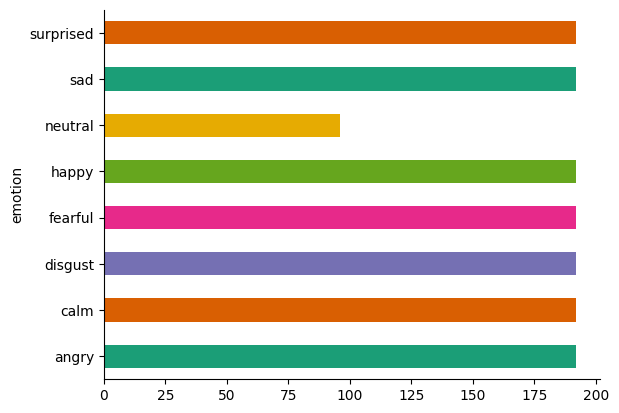

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()['audio']

Labels:  ['angry' 'calm' 'disgust' 'fearful' 'surprised' 'happy' 'sad' 'neutral']



emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: audio, dtype: int64

Restructuring the dataframe a bit for clarity:

In [ ]:
df["path"] = df["audio"].apply(lambda audio: audio.get("path", None))



KeyError: 'audio'

In [ ]:
df.head()

,text,labels,speaker_id,speaker_gender,emotion,path
0,Kids are talking by the door,4,18,female,angry,/content/cache/downloads/extracted/90a2946071f...
1,Dogs are sitting by the door,1,18,female,calm,/content/cache/downloads/extracted/90a2946071f...
2,Kids are talking by the door,6,18,female,disgust,/content/cache/downloads/extracted/90a2946071f...
3,Kids are talking by the door,1,18,female,calm,/content/cache/downloads/extracted/90a2946071f...
4,Dogs are sitting by the door,6,18,female,disgust,/content/cache/downloads/extracted/90a2946071f...


Now we are gonna split the dataset into a train and test split and also save them into content/data as csv files:

In [ ]:
import os

save_path = "/content/data"

os.makedirs(save_path, exist_ok=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["labels"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 6)
(288, 6)


In [ ]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "/content/data/train.csv",
    "validation": "/content/data/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
print(dataset['train'][0])
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'text': 'Dogs are sitting by the door', 'labels': 2, 'speaker_id': 15, 'speaker_gender': 'male', 'emotion': 'happy', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_15/03-01-03-01-02-01-15.wav'}
Dataset({
    features: ['text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path'],
    num_rows: 1152
})
Dataset({
    features: ['text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path'],
    num_rows: 288
})


In [ ]:
unique_labels = df["emotion"].unique()
print(unique_labels)
print(f"A classification problem with {len(unique_labels)} emotions.")

['angry' 'calm' 'disgust' 'fearful' 'surprised' 'happy' 'sad' 'neutral']
A classification problem with 8 emotions.


# Loading in the Wav2Vec2 model

In [ ]:
from transformers import AutoConfig, Wav2Vec2Processor

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
model_name_or_path = "facebook/Wav2Vec2-Base-960h"
pooling_mode = "mean"

In [ ]:
print(label2id)
print(id2label)

# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=len(unique_labels),
    label2id=label2id,
    id2label=id2label,
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)
print(config)

{'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
Wav2Vec2Config {
  "_name_or_path": "facebook/Wav2Vec2-Base-960h",
  "activation_dropout": 0.1,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": f

In [ ]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [ ]:
all_wav = df['path'].str.endswith('.wav').all()

if all_wav:
    print("All files have the .wav format.")
else:
    print("Not all files have the .wav format.")

All files have the .wav format.


In [ ]:
def speech_file_to_array_fn(path):
    try:
        # Load and resample the audio
        speech_array, sampling_rate = torchaudio.load(path)
        resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
        speech = resampler(speech_array)

        # Ensure consistent shape
        if speech.dim() > 1:
            print("Multidimensional speech at path: ", path)
            speech = speech.squeeze()

        # Convert to numpy array and ensure 1D
        speech = speech.numpy()
        if len(speech.shape) != 1:
            raise ValueError("Expected a 1D numpy array of float values.")

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        # Return a consistent placeholder (empty array)
        speech = np.array([])

    return speech


def preprocess_function(examples):
    speech_list = []

    # Check if 'path' exists in 'examples'
    if "path" in examples:
        for path in examples["path"]:
            # Ensure the path exists and is a valid .wav file
            if not isinstance(path, str) or not path.endswith(".wav"):
                speech_list.append(np.array([]))  # Placeholder for invalid paths
                continue

            speech = speech_file_to_array_fn(path)
            speech_list.append(speech)  # Append valid or empty (if error occurs)

    # Remove empty arrays
    speech_list = [s for s in speech_list if s.size > 0]

    # Check if there's any valid data to process
    if not speech_list:
        return {}  # Return an empty result for safety

    # Process the list with the Wav2Vec2Processor
    result = processor(speech_list, sampling_rate=target_sampling_rate)

    return result

In [ ]:
print(train_dataset[873:880])  # This can help identify any irregularities


{'text': ['Kids are talking by the door', 'Dogs are sitting by the door', 'Dogs are sitting by the door', 'Dogs are sitting by the door', 'Kids are talking by the door', 'Kids are talking by the door', 'Kids are talking by the door'], 'labels': [7, 0, 6, 4, 4, 3, 0], 'speaker_id': [12, 13, 20, 10, 3, 12, 21], 'speaker_gender': ['female', 'male', 'female', 'female', 'male', 'female', 'male'], 'emotion': ['surprised', 'neutral', 'disgust', 'angry', 'angry', 'sad', 'neutral'], 'path': ['/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_12/03-01-08-01-01-02-12.wav', '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_13/03-01-01-01-02-01-13.wav', '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_20/03-01-07-02-02-02-20.wav', '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/

In [ ]:
train_dataset = train_dataset.filter(lambda x: x["path"] and os.path.exists(x["path"]))
eval_dataset = eval_dataset.filter(lambda x: x["path"] and os.path.exists(x["path"]))


Filter:   0%|          | 0/1152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/288 [00:00<?, ? examples/s]

In [ ]:
# Check a range of samples to spot anomalies
for i in range(870, 880):  # Adjust the range as needed
    try:
        # Attempt to access the example and see if it throws errors
        print(f"Sample {i}: ", train_dataset[i])
    except Exception as e:
        print(f"Error at sample {i}: {e}")

Sample 870:  {'text': 'Kids are talking by the door', 'labels': 1, 'speaker_id': 11, 'speaker_gender': 'male', 'emotion': 'calm', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_11/03-01-02-01-01-02-11.wav'}
Sample 871:  {'text': 'Kids are talking by the door', 'labels': 4, 'speaker_id': 18, 'speaker_gender': 'female', 'emotion': 'angry', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_18/03-01-05-01-01-02-18.wav'}
Sample 872:  {'text': 'Kids are talking by the door', 'labels': 4, 'speaker_id': 22, 'speaker_gender': 'female', 'emotion': 'angry', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_22/03-01-05-02-01-01-22.wav'}
Sample 873:  {'text': 'Kids are talking by the door', 'labels': 7, 'speaker_id': 12, 'speaker_gender': 'female', 'emotion': 'surprised', 'path': '/content/cache/download

In [ ]:
print(train_dataset.features)  # Check if 'path' is a valid column name

print(len(train_dataset))
# Define a filter function to check if the path exists
def path_exists(example):
    return os.path.exists(example["path"])  # Adjust based on your column name

# Apply the filter to remove invalid paths
train_dataset = train_dataset.filter(path_exists)
print(len(train_dataset))

{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'speaker_id': Value(dtype='int64', id=None), 'speaker_gender': Value(dtype='string', id=None), 'emotion': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None), 'input_values': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}
1152


Filter:   0%|          | 0/1152 [00:00<?, ? examples/s]

1152


In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

Map (num_proc=4):   0%|          | 0/1152 [00:00<?, ? examples/s]

Error processing file /content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_01/03-01-02-01-01-02-01.wav: Expected a 1D numpy array of float values.
Error processing file /content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_20/03-01-03-01-02-01-20.wav: Expected a 1D numpy array of float values.


ArrowInvalid: Column 6 named input_values expected length 88 but got length 87